<a href="https://colab.research.google.com/github/richardtekere09/Image-recognition-methods/blob/main/Another_copy_of_Semantic_Segmentation_on_GTA_5_with_UNet%2B%2B_(PyTorch_%2B_SMP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install torch torchvision timm segmentation-models-pytorch

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import Adam
import segmentation_models_pytorch as smp #SMP models
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import os
from pathlib import Path
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau


Setting paths from the lab handout

In [ ]:
train_images_path ="/content/drive/MyDrive/Resized images/Images/Train"
train_masks_path ="/content/drive/MyDrive/Resized images/Masks/Train"
test_images_path ="/content/drive/MyDrive/Resized images/Images/Test"
test_masks_path ="/content/drive/MyDrive/Resized images/Masks/Test"

SEED=42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


Custom Dataset class

In [ ]:
# ============================================
# UPDATED DATASET CLASS FOR ALBUMENTATIONS
# ============================================

from pathlib import Path
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset

class GTA5Dataset(Dataset):
    """Custom Dataset for GTA5 segmentation with Albumentations"""

    def __init__(self, images_path, masks_path, transform=None):
        self.images_path = Path(images_path)
        self.masks_path = Path(masks_path)
        self.transform = transform

        self.image_files = sorted([f for f in os.listdir(images_path) if f.endswith(('.png', '.jpg'))])
        self.mask_files = sorted([f for f in os.listdir(masks_path) if f.endswith(('.png', '.jpg'))])

        assert len(self.image_files) == len(self.mask_files), "Mismatch between images and masks"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = self.images_path / self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        image = np.array(image)

        # Load mask
        mask_path = self.masks_path / self.mask_files[idx]
        mask = Image.open(mask_path)
        mask = np.array(mask)

        # Apply albumentations transform (transforms BOTH image and mask)
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        else:
            # Fallback if no transform
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
            mask = torch.from_numpy(mask).long()

        # Ensure mask is long tensor (for CrossEntropyLoss)
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask).long()
        else:
            mask = mask.long()

        return image, mask

TRANSFORMS (PREPROCESSING)

In [ ]:
!pip install albumentations

import albumentations as A
from albumentations.pytorch import ToTensorV2


# Training transforms - applies SAME transform to image AND mask
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),                    # Flips BOTH image and mask
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()                                 # Converts both to tensors
])

# Test transforms - no augmentation
test_transform = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

CREATE DATASETS AND DATALOADERS

In [ ]:
# Recreate datasets
train_dataset = GTA5Dataset(train_images_path, train_masks_path, transform=train_transform)
test_dataset = GTA5Dataset(test_images_path, test_masks_path, transform=test_transform)

# Recreate dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 301
Test samples: 201


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Quick visual check

Image shape: torch.Size([3, 256, 480])
Mask shape: torch.Size([256, 480])
Image type: torch.float32
Mask type: torch.int64
Image range: [-2.118, 2.466]
Mask range: [0, 27]


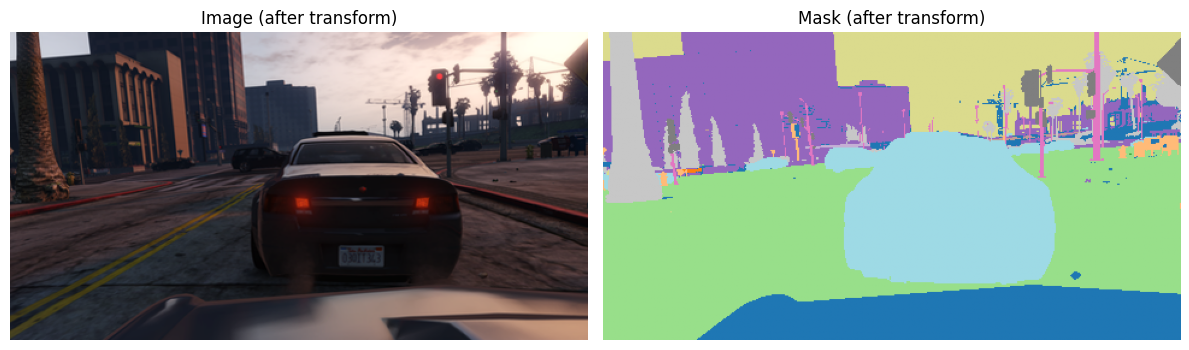

In [ ]:
# ============================================
# TEST TRANSFORMS
# ============================================

# Get one sample
image, mask = train_dataset[0]

print(f"Image shape: {image.shape}")  # Should be [3, 256, 480]
print(f"Mask shape: {mask.shape}")    # Should be [256, 480]
print(f"Image type: {image.dtype}")   # Should be torch.float32
print(f"Mask type: {mask.dtype}")     # Should be torch.int64 or torch.long
print(f"Image range: [{image.min():.3f}, {image.max():.3f}]")
print(f"Mask range: [{mask.min()}, {mask.max()}]")

# Visualize to verify alignment
import matplotlib.pyplot as plt

def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Show image
img_display = denormalize(image.clone())
img_display = img_display.permute(1, 2, 0).numpy()
img_display = np.clip(img_display, 0, 1)

axes[0].imshow(img_display)
axes[0].set_title('Image (after transform)')
axes[0].axis('off')

axes[1].imshow(mask.numpy(), cmap='tab20')
axes[1].set_title('Mask (after transform)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

Build UNet++ model

In [ ]:
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b0",    # Backbone
    encoder_weights="imagenet",         # Pre-trained weights
    in_channels=3,                      # RGB
    classes=35                          # 35 segmentation classes
).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print("\n=== Model Architecture ===")
print(f"Encoder: efficientnet-b4 (pre-trained on ImageNet)")
print(f"Decoder: UNet++ with nested skip connections")
print(f"Input: 3 channels (RGB)")
print(f"Output: 35 classes")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Model parameters: 6,574,511

=== Model Architecture ===
Encoder: efficientnet-b4 (pre-trained on ImageNet)
Decoder: UNet++ with nested skip connections
Input: 3 channels (RGB)
Output: 35 classes


LOSS FUNCTION AND OPTIMIZER

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)
# criterion = smp.losses.FocalLoss(mode='multiclass', alpha=0.25, gamma=2.0)

print(f"\nLoss: CrossEntropyLoss")
print(f"Optimizer: Adam (lr=1e-4)")


Loss: CrossEntropyLoss
Optimizer: Adam (lr=1e-4)


TRAINING LOOP

In [ ]:
# ============================================
# CORRECTED CODE WITH PROPER INDENTATION
# ============================================
def evaluate_model(model, test_loader, criterion, n_classes=35):
    """Evaluate model on test set"""

    print("\n=== Evaluating Model ===")
    model.eval()

    total_correct = 0
    total_pixels = 0
    test_loss = 0
    total_miou = 0

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            test_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)

            # Calculate pixel accuracy
            total_pixels += masks.numel()
            total_correct += (predicted == masks).sum().item()

            # Calculate mIoU
            batch_miou = calculate_mIoU(predicted, masks, n_classes)
            if not np.isnan(batch_miou):
                total_miou += batch_miou

    # Print results
    avg_loss = test_loss / len(test_loader)
    pixel_accuracy = 100 * total_correct / total_pixels
    mean_iou = 100 * total_miou / len(test_loader)

    print(f"\n=== Test Results ===")
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Pixel Accuracy: {pixel_accuracy:.2f}%")
    print(f"Mean IoU (mIoU): {mean_iou:.2f}%")

    return avg_loss, pixel_accuracy, mean_iou


# Calculate class weights
def calculate_class_weights(train_loader, n_classes=35):
    class_counts = torch.zeros(n_classes)

    for _, masks in train_loader:  # Fixed indentation
        for cls in range(n_classes):  # Fixed indentation
            class_counts[cls] += (masks == cls).sum().item()

    class_counts[class_counts == 0] = 1e-6
    total_pixels = class_counts.sum()
    weights = total_pixels / (n_classes * class_counts)
    weights = weights / weights.mean()
    weights = torch.clamp(weights, 0.1, 10.0)

    return weights.to(device)  # Fixed indentation

# Calculate weights
weights = calculate_class_weights(train_loader)
print(f"Class weights range: {weights.min():.2f} - {weights.max():.2f}")

criterion = nn.CrossEntropyLoss(weight=weights)

#LEARNING RATE SCHEDULER
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# 8. TRAINING WITH VALIDATION
def train_model_with_validation(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=30):
    print("\n=== Starting Training ===")
    best_loss = float('inf')

    for epoch in range(num_epochs):
        # TRAINING
        model.train()
        train_loss = 0.0

        for batch_idx, (images, masks) in enumerate(train_loader):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if (batch_idx + 1) % 4 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        avg_train_loss = train_loss / len(train_loader)

        # VALIDATION EVERY EPOCH
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in test_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(test_loader)

        print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        # Update learning rate
        scheduler.step(avg_val_loss)

        # Save best model
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'  ✓ Best model saved! Val Loss: {best_loss:.4f}')

        print()

    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    return model

# 9. TRAIN
num_epochs = 30
model = train_model_with_validation(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs)

# 10. EVALUATE
print("\n=== Final Evaluation ===")
_, pixel_acc, miou = evaluate_model(model, test_loader, criterion)
print(f"Pixel Accuracy: {pixel_acc:.2f}%")
print(f"Mean IoU: {miou:.2f}%")


Class weights range: 0.10 - 5.00

=== Starting Training ===
Epoch [1/30], Step [4/19], Loss: 2.4510
Epoch [1/30], Step [8/19], Loss: 2.3137
Epoch [1/30], Step [12/19], Loss: 2.2281
Epoch [1/30], Step [16/19], Loss: 2.1021
Epoch [1/30] - Train Loss: 2.2597, Val Loss: 2.0563
  ✓ Best model saved! Val Loss: 2.0563

Epoch [2/30], Step [4/19], Loss: 1.9992
Epoch [2/30], Step [8/19], Loss: 1.9595
Epoch [2/30], Step [12/19], Loss: 1.8496
Epoch [2/30], Step [16/19], Loss: 1.8214
Epoch [2/30] - Train Loss: 1.9079, Val Loss: 1.8150
  ✓ Best model saved! Val Loss: 1.8150

Epoch [3/30], Step [4/19], Loss: 1.7309
Epoch [3/30], Step [8/19], Loss: 1.6729
Epoch [3/30], Step [12/19], Loss: 1.6505
Epoch [3/30], Step [16/19], Loss: 1.6236
Epoch [3/30] - Train Loss: 1.6859, Val Loss: 1.6476
  ✓ Best model saved! Val Loss: 1.6476

Epoch [4/30], Step [4/19], Loss: 1.5625
Epoch [4/30], Step [8/19], Loss: 1.4904
Epoch [4/30], Step [12/19], Loss: 1.4883
Epoch [4/30], Step [16/19], Loss: 1.4257
Epoch [4/30] - T

In [ ]:
# ============================================
# CLEAR GPU MEMORY
# ============================================

import torch
import gc

# Delete old model and clear cache
if 'model' in globals():
    del model

torch.cuda.empty_cache()
gc.collect()

print(f"GPU Memory cleared!")
print(f"Allocated: {torch.cuda.memory_allocated(0)/1024**3:.2f} GB")
print(f"Reserved: {torch.cuda.memory_reserved(0)/1024**3:.2f} GB")

GPU Memory cleared!
Allocated: 14.40 GB
Reserved: 14.59 GB


Train the model

EVALUATION METRIC (mIoU)

In [ ]:

def calculate_mIoU(pred, target, n_classes):
    """Calculate mean Intersection over Union"""
    ious = []
    pred = pred.cpu().numpy()
    target = target.cpu().numpy()

    for cls in range(n_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)

        intersection = np.logical_and(pred_cls, target_cls).sum()
        union = np.logical_or(pred_cls, target_cls).sum()

        if union == 0:
            ious.append(float('nan'))  # Ignore if class not present
        else:
            ious.append(intersection / union)

    return np.nanmean(ious)

TESTING/EVALUATION

In [ ]:

def evaluate_model(model, test_loader, criterion, n_classes=35):
    """Evaluate model on test set"""

    print("\n=== Evaluating Model ===")
    model.eval()

    total_correct = 0
    total_pixels = 0
    test_loss = 0
    total_miou = 0

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            test_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)

            # Calculate pixel accuracy
            total_pixels += masks.numel()
            total_correct += (predicted == masks).sum().item()

            # Calculate mIoU
            batch_miou = calculate_mIoU(predicted, masks, n_classes)
            if not np.isnan(batch_miou):
                total_miou += batch_miou

    # Print results
    avg_loss = test_loss / len(test_loader)
    pixel_accuracy = 100 * total_correct / total_pixels
    mean_iou = 100 * total_miou / len(test_loader)

    print(f"\n=== Test Results ===")
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Pixel Accuracy: {pixel_accuracy:.2f}%")
    print(f"Mean IoU (mIoU): {mean_iou:.2f}%")

    return avg_loss, pixel_accuracy, mean_iou

# Evaluate the model
#test_loss, pixel_acc, miou = evaluate_model(model, test_loader, criterion)

VISUALIZE PREDICTIONS

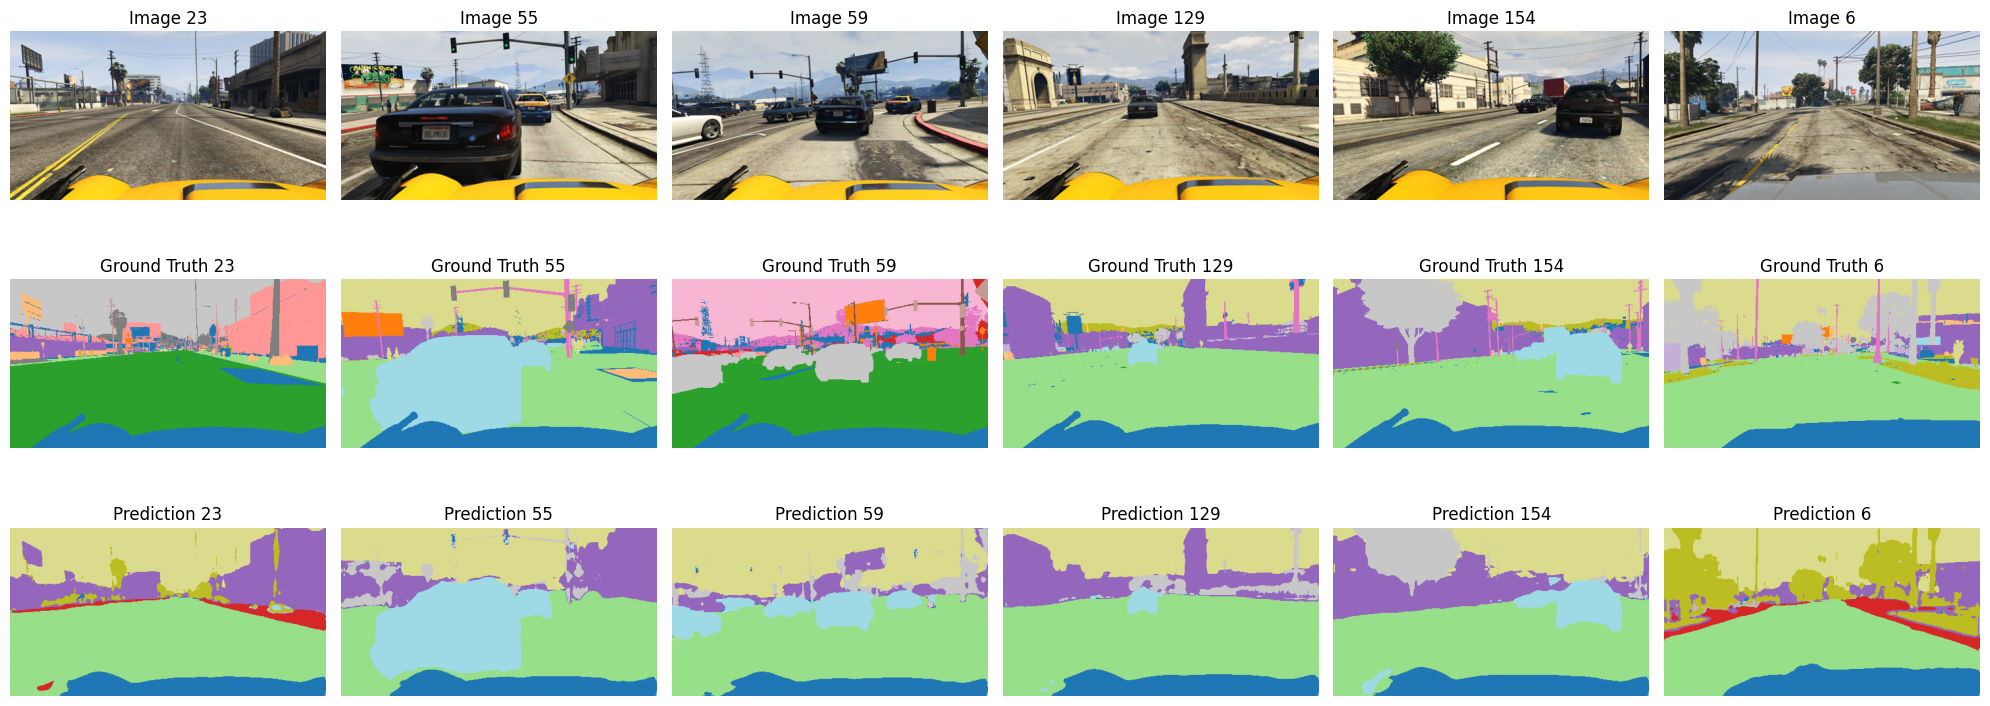

In [ ]:

def visualize_predictions(model, test_dataset, num_images=12):
    """Visualize model predictions"""

    model.eval()
    random_indices = random.sample(range(len(test_dataset)), num_images)

    fig, axes = plt.subplots(3, num_images, figsize=(20, 8))

    with torch.no_grad():
        for i, idx in enumerate(random_indices):
            image, mask = test_dataset[idx]

            # Denormalize for display
            img_display = denormalize(image.clone())
            img_display = img_display.permute(1, 2, 0).numpy()
            img_display = np.clip(img_display, 0, 1)

            # Original image
            axes[0, i].imshow(img_display)
            axes[0, i].set_title(f'Image {idx}')
            axes[0, i].axis('off')

            # Ground truth mask
            axes[1, i].imshow(mask.numpy(), cmap='tab20')
            axes[1, i].set_title(f'Ground Truth {idx}')
            axes[1, i].axis('off')

            # Prediction
            input_tensor = image.unsqueeze(0).to(device)
            output = model(input_tensor)
            predicted = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

            axes[2, i].imshow(predicted, cmap='tab20')
            axes[2, i].set_title(f'Prediction {idx}')
            axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

# Show predictions
visualize_predictions(model, test_dataset, num_images=6)
